# CS-E4895: Gaussian Processes (2023)

# Assignment #2: Squared Exponential Kernel and Marginal likelihood

### Learning objectives

After completing this lab exercise, you should be able to:

- Implement the squared exponential kernel and explain the interpretation of each parameter
- Generate samples from a Gaussian process prior
- Compute the posterior & predictive distributions for a Gaussian process model with Gaussian likelihood
- Compute the marginal likelihood and use it for model selection

**Note:** All exercises must be solved using numpy only.

This assignment consists of 4 smaller tasks, but the assignment grading will be still 0..6 points.

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
snb.set(font_scale=1.5)

### Task 1: The squared exponential kernel

The squared exponential covariance function is given by

\begin{align}
    k(\mathbf{x}_n, \mathbf{x}_m) = \alpha \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right),
\end{align}

where $\alpha > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponeniated quadratic kernel. 

Below you are given a vector $\mathbf{X}^p \in \mathbb{R}^{N \times 1}$ of $N = 50$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-3, 9\right]$. 

- **Task 1a**: Complete the implementation of the squared exponential kernel function below. (Hint: the code only needs to work with $D=1$).

- **Task 1b**: Use the kernel function to compute the $N\times N$ kernel matrix for the points $\mathbf{X}^p$ with $\alpha=1$ and $\ell=1$. These points will be used for predictions later and hence, the superscript 'p'. Visualize the kernel function as an image and give an interpretation of the structure of the kernel. ('imshow' function)

- **Task 1c**: Try few other parameter values $\alpha, \ell$ and explain how they affect the structure of the kernel.

In [2]:
# create an Nx1 vector of equidistant points in [-3, 3]
N = 50
Xp = np.linspace(-3, 9, N)[:, None]

# Task 1a
def create_se_kernel(X1, X2, alpha=1, scale=1):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1    -- NxD matrix
    X2    -- MxD matrix
    alpha -- scalar 
    scale -- scalar
    
    returns NxM matrix    
    """
    #print(np.sum(X1**2, axis=1)[:, np.newaxis].shape)
    #print(np.sum(X2**2, axis=1).shape)
    #dist_sq = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    dist_sq = np.sum((X1[:,None] - X2) **2, axis=2)
    
    kernel_matrix = alpha * np.exp(-dist_sq / (2 * (scale**2)))
    return kernel_matrix
    ###############################################
    # ------- insert code here -------------------
    ###############################################



The RBF matrix shape is (50, 50)


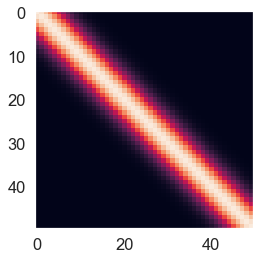

In [3]:
# Task 1b

Kpp = create_se_kernel(Xp, Xp, alpha=1, scale=1)
plt.imshow(Kpp, interpolation='None')
plt.grid(False)
print(f"\nThe RBF matrix shape is {Kpp.shape}")

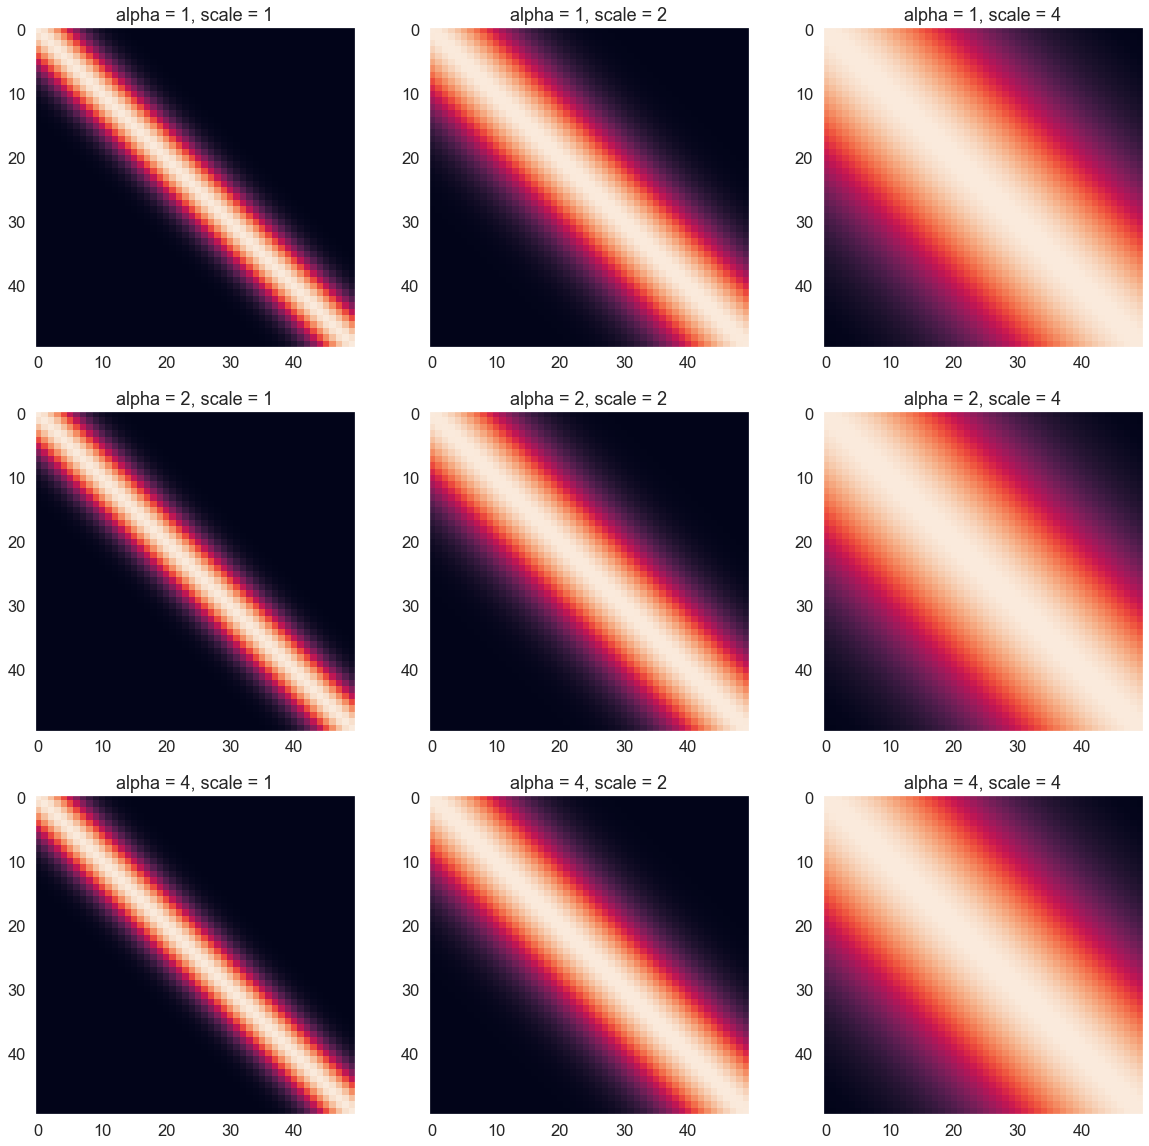

In [4]:
# Task 1c
fig,ax=plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
alphas = [1, 2, 4]
scales = [1, 2, 4]

X1, X2 = np.meshgrid(Xp, Xp)

for indexAlpha, alpha in enumerate(alphas):
    for indexScale, scale in enumerate(scales):
        K = create_se_kernel(Xp, Xp, alpha, scale)
        cp = ax[indexAlpha][indexScale].imshow(K, interpolation='None')
        ax[indexAlpha][indexScale].grid(False)
        ax[indexAlpha][indexScale].set_title(f"alpha = {alpha}, scale = {scale}")
        #fig.colorbar(cp) # Add a colorbar to a plot



Basically, the RBF kernel tries to measure the similarity between two vectors (Xp and Xp). From the above figure, we can see that the main diagonal has high RBF values, and the value gradually decreases as it moves further away from the diagonal. The distribution of the RBF is a bell-shape (like normal distribution) with the center defined at the point where two elements from the two vectors are exactly equal. The brightest region in the heatmap is called the Region Of Similarity.

How the hyperparameters affect the RBF kernel:

The alpha parameter controls the scaling of the kernel function. A larger value of alpha results in a larger scaling factor, which in turn leads to larger kernel values for all pairs of input vectors. This means that increasing alpha will increase the overall similarity between input vectors, leading to a broader and more diffuse region of similarity. Conversely, decreasing alpha will result in a narrower and more concentrated region of similarity.

The scale parameter controls the width of the Region of Similarity. The larger the scale, the wider this region becomes and vice versa. When the scale is larger, the kernel function will decrease more slowly with distance, resulting in a wider region of similarity. Conversely, a smaller value of ell means that the kernel function will decrease more quickly with distance, resulting in a narrower region of similarity. 

### Task 2: Sampling from a Gaussian process

We will consider a zero-mean Gaussian process prior for functions of the form $f: \mathbb{R} \rightarrow \mathbb{R}$ using the squared exponential kernel from task 1). That is,

\begin{align}
f(x) \sim \mathcal{GP}\left(0 \, , \, k\left(x, x'\right)\right).
\end{align}

Let $f_n = f(x_n) \in \mathbb{R}$ be the value of the function $f$ evaluated at a point $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{f} = \left[f_1, f_2, \dots, f_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points of $\mathbf{X}^p$ from task 1. 

The Gaussian process prior for $\mathbf{f}$ becomes

\begin{align}
\mathbf{f} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right),
\end{align}

where $\mathbf{K}$ is the kernel matrix you generated previously.

- **Task 2a**: Complete the implementation of the sampling function given below. Hint: You can re-use the code from first exercise.
- **Task 2b**: Generate $M = 10$ samples using the new function and plot them
- **Task 2c**: Change the parameters $\alpha, \ell$ and explain how they affect the generated samples.


In [5]:
# Task 2a

def generate_samples(mean, K, M):
    """ returns M samples from a zero-mean Gaussian process with kernel matrix K
    
    arguments:
    K   -- NxN kernel matrix
    M   -- number of samples (scalar)
    
    returns NxM matrix
    """
    jitter = 1e-8
    L = np.linalg.cholesky(K + jitter * np.identity(len(K)))
    zs = np.random.normal(0, 1, size=(len(K), M))
    fs = mean + np.dot(L, zs)
    return fs
    ###############################################
    # ------- insert code here -------------------
    ###############################################

The sample shape is
(50, 10)


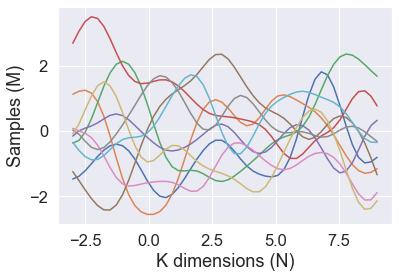

In [6]:
# Task 2b

# Number of samples
M = 10
# The mean vector
mean = np.zeros(M)

Kpp = create_se_kernel(Xp, Xp, alpha=1, scale=1)
samples = generate_samples(mean, Kpp, M)

print("The sample shape is")
print(samples.shape)

plt.plot(Xp, samples)

# Plotting the samples
plt.ylabel('Samples (M)')
plt.xlabel('K dimensions (N)')
# Show the plot
plt.show()

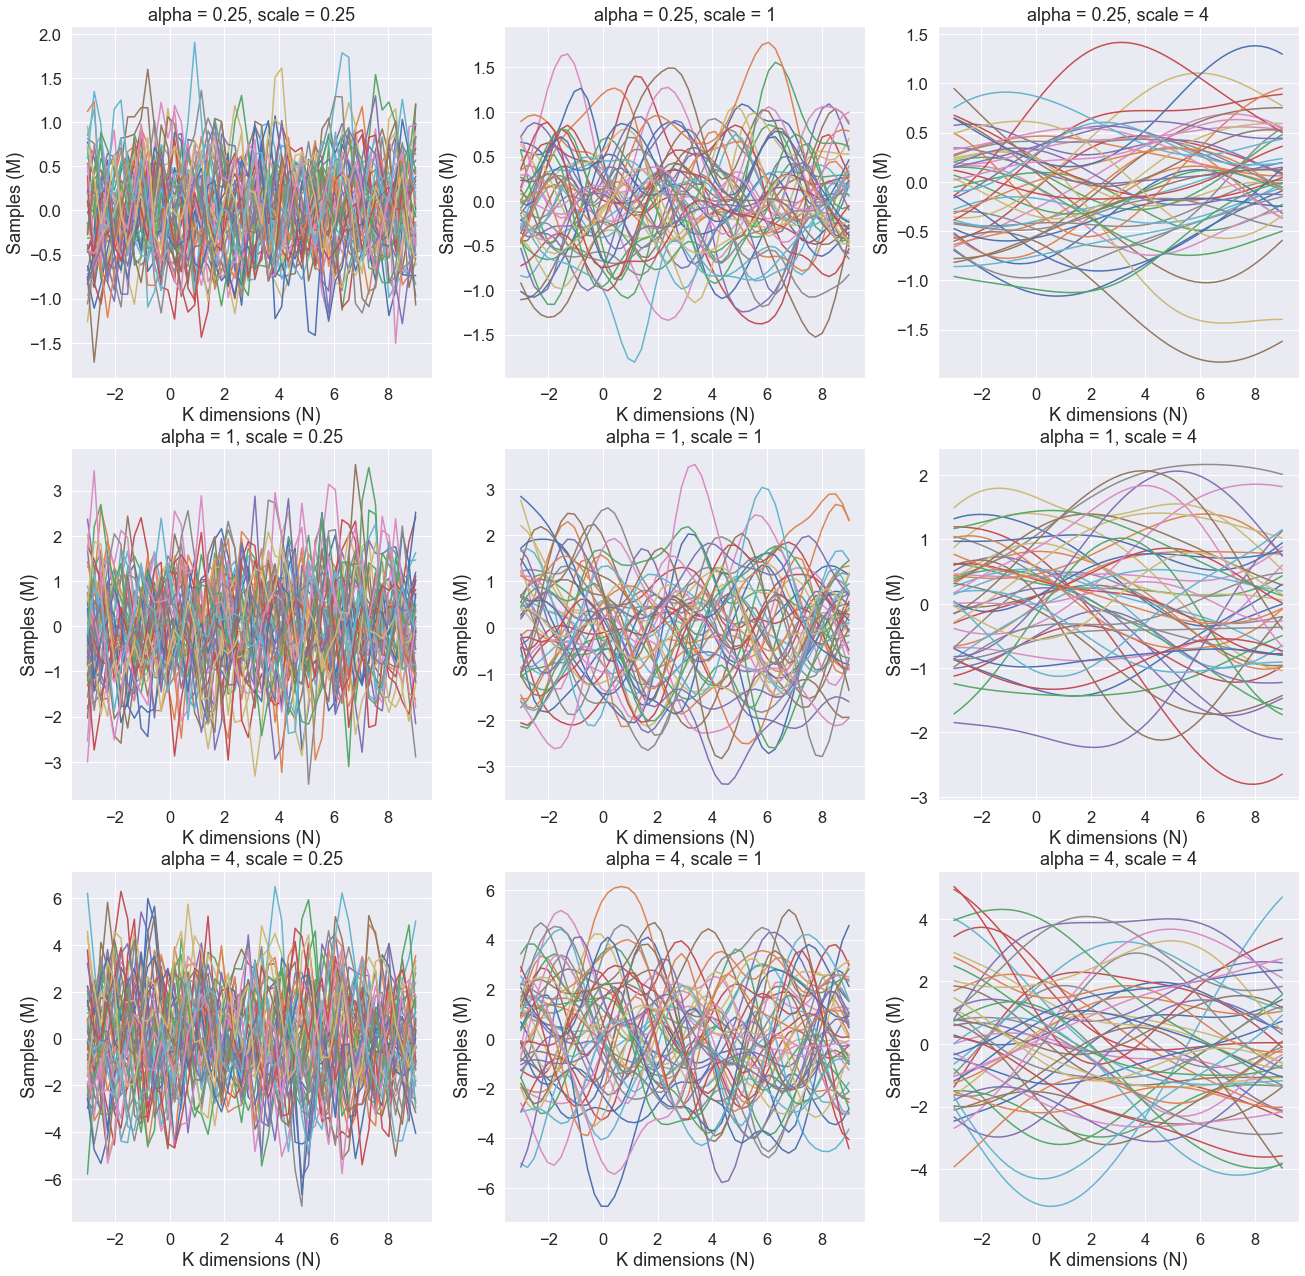

In [7]:
# Task 2c

fig,ax=plt.subplots(nrows=3, ncols=3, figsize=(22, 22))
alphas = [0.25, 1, 4]
scales = [0.25, 1, 4]
M_test = 50
mean = np.zeros(M_test) 

for indexAlpha, alpha in enumerate(alphas):
    for indexScale, scale in enumerate(scales):
        K = create_se_kernel(Xp, Xp, alphas[indexAlpha], scales[indexScale])
        samples = generate_samples(mean, K, M_test)
        ax[indexAlpha][indexScale].plot(Xp, samples)
        ax[indexAlpha][indexScale].set_title(f"alpha = {alpha}, scale = {scale}")
        ax[indexAlpha][indexScale].set_ylabel('Samples (M)')
        ax[indexAlpha][indexScale].set_xlabel('K dimensions (N)')
        #fig.colorbar(cp) # Add a colorbar to a plot

Given a mean of 0 and a covariance matrix defined by the RBF kernel, the hyperparameters alpha and scale affect the distribution of the multivariate samples as follows:

The alpha parameter scales the magnitude of the RBF kernel. A higher value of alpha will result in a covariance matrix with higher variances and stronger correlations between the dimensions. This means that the samples will be more spread out and have a higher correlation between dimensions. This can be seen that as the alpha parameter increases, the samples become similar in pattern along the samples axis

The scale parameter controls the smoothness of the samples. A higher value of scale will result in a covariance matrix with smoother and more gradual changes in the correlation between dimensions. This means that the samples will be less likely to have sudden changes in value between dimensions. This can be seen that as the scale parameter increases, the samples become smoother along the K dimensions axis

### Task 3: The analytical posterior distribution

The goal of this task is complete the implementation of the function below for computing the analytical posterior distribution for a Gaussian process model with Gaussian likelihood, respectively, using the squared exponential kernel.

The joint model for the training data is as follows:
\begin{align}
p(\mathbf{y}, \mathbf{f}) = \mathcal{N}\left(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)\mathcal{N}\left(\mathbf{f} | \mathbf{0}, \mathbf{K}\right)
\end{align}





Below you are given a simple toy data set $\mathcal{D} = \left\lbrace x_n, y_n \right\rbrace_{n=1}^N$ for $N = 50$ as visualized below


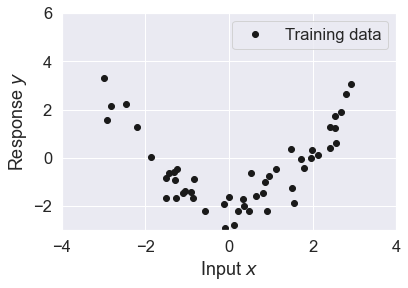

In [8]:
# load data
data = np.load('assignment2_data.npz')
N = data['N']
X = data['X']
y = data['y']

plt.plot(X, y, 'k.', markersize=12, label='Training data')
plt.grid(True)
plt.xlim((-4, 4))
plt.ylim((-3, 6))
plt.xlabel('Input $x$')
plt.ylabel('Response $y$')
plt.legend();


**Task 3a**: Complete the implementation of the function <tt>posterior</tt> that computes the posterior

\begin{align*}
p(f_* | X,y,X^p) = \mathcal{N} \left(f_* \big| K_{f_* f} (K_{ff} + \sigma^2)^{-1} y, K_{f_* f_*} - K_{f_* f} (K_{ff} + \sigma^2)^{-1} K_{f_* f}^T \right)
\end{align*}


In [9]:
def posterior(Xp, X, y, alpha, scale, sigma2):
    """ returns the posterior distribution of f evaluated at each of the points in Xp conditioned on (X, y)
        using the squared exponential kernel.
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """

    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    K_f_f = create_se_kernel(X, X, alpha=alpha, scale=scale)
    K_fstar_f = create_se_kernel(Xp, X, alpha=alpha, scale=scale)
    K_fstar_fstar = create_se_kernel(Xp, Xp, alpha=alpha, scale=scale)
    
    post_mu = K_fstar_f @ np.linalg.inv(K_f_f + sigma2 * np.eye(X.shape[0])) @ y
    post_cov = K_fstar_fstar - K_fstar_f @ np.linalg.inv(K_f_f + sigma2 * np.eye(X.shape[0])) @ K_fstar_f.T
    return post_mu, post_cov



**Task 3b**: Compute the prior & posterior of $f(\mathbf{X}_p)$ with $\sigma^2 = \frac{1}{2}$, $\alpha=1$, and <tt>scale</tt>=2, where $\mathbf{X}_p$ is the vector from task 1.


In [10]:
sigma2 = 0.5
alpha = 1
scale = 1

print(f"P = {Xp.shape[0]}")
print(f"D = {Xp.shape[1]}")
print(f"N = {X.shape[0]}")

# prior mean and covariance
mu_prior, Sigma_prior = posterior(Xp, np.zeros((0,1)), np.zeros((0,1)), alpha, scale, sigma2)
print(f"Shape of mu_prior is {mu_prior.shape}")
print(f"Shape of Sigma_prior is {Sigma_prior.shape}")
# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)
print(f"Shape of mu_post is {mu_post.shape}")
print(f"Shape of Sigma_post is {Sigma_post.shape}")

P = 50
D = 1
N = 50
Shape of mu_prior is (50, 1)
Shape of Sigma_prior is (50, 50)
Shape of mu_post is (50, 1)
Shape of Sigma_post is (50, 50)


**Task 3c**: If the functions above have been implemented correctly, then the following two plots below will show the training data superimposed with prior and posterior, respectively. First, explain what you see in the two figures. Second, what is the difference between the prior and the posterior in 1) regions close to the data points 2) in regions far from the data points?



(50, 1)
(50, 1)
(50, 50)
(50, 50)


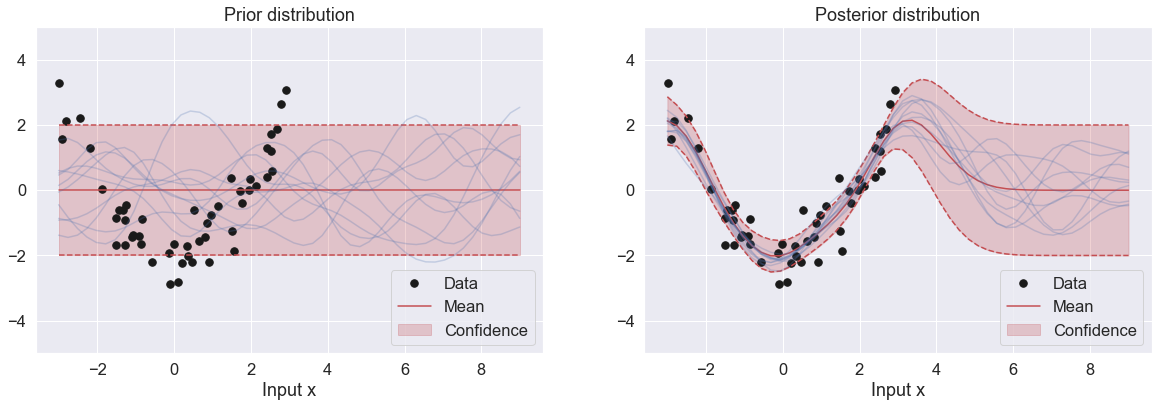

In [11]:
def plot_with_uncertainty(Xp, mu, Sigma, color='r', color_samples='b', title="", num_samples=0):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    
    # plot distribution
    plt.plot(Xp, mean, color=color, label='Mean')
    plt.plot(Xp, mean + 2*std, color=color, linestyle='--')
    plt.plot(Xp, mean - 2*std, color=color, linestyle='--')
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='Confidence')
    
    # generate samples
    if num_samples > 0:
        fs = generate_samples(mu, Sigma, 10)
        plt.plot(Xp, fs, color=color_samples, alpha=.25)
    
    plt.title(title)
    
def plot_data():
    plt.plot(X, y, 'k.', markersize=15, label='Data')
    plt.xlabel('Input x')
    plt.ylim((-5, 5))
    plt.grid(True)

    
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_data()
plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title='Prior distribution', num_samples=10)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior distribution', num_samples=10)
plt.legend(loc='lower right')

print(mu_prior.shape)
print(mu_post.shape)
print(Sigma_prior.shape)
print(Sigma_post.shape)

Explain what you see in the two figures?

In the first figure, the prior mean is 0, and the prior variance is based on rbf of the testing data. The mean is set at 0 and the confidence level is within the [-2,2] range along the response. This prior is uniformly distributed

In the second figure, the posterior mean follows closely the data pattern from -4 to 4 along the x-input. After that, the posterior starts to resemble the prior again. 

What is the difference between the prior and the posterior in 

1) regions close to the data points 

The prior is uniform in this region because it does not consider the datapoints

The posterior takes into account this region and it closely follows the datapoints

2) in regions far from the data points?

There is no difference between the prior and posterior in regions far from the data points

**Task 3d**: Replicate the two figures above for the following three different values of the scale parameter: $\left\lbrace 0.1, 1., 10 \right\rbrace$ and for $\sigma^2 = \frac{1}{2}$ and $\alpha=1$. Explain the differences between the three sets of plots


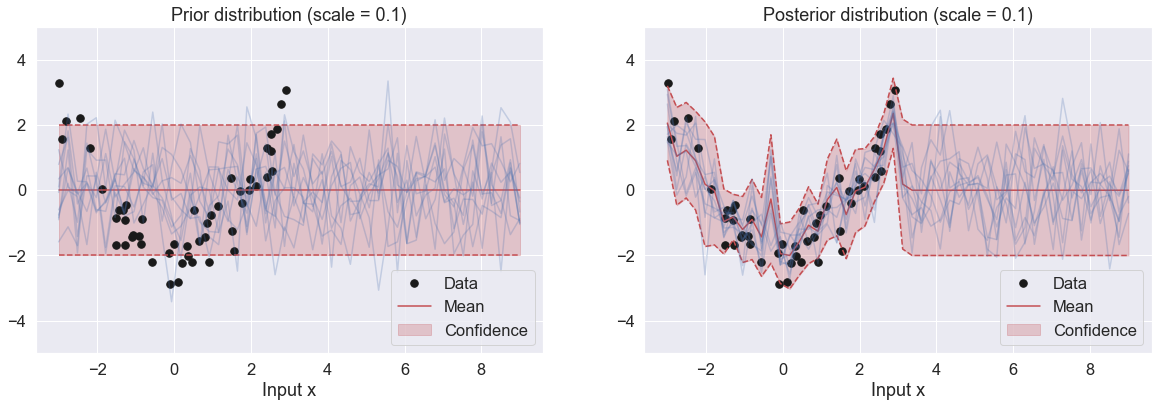

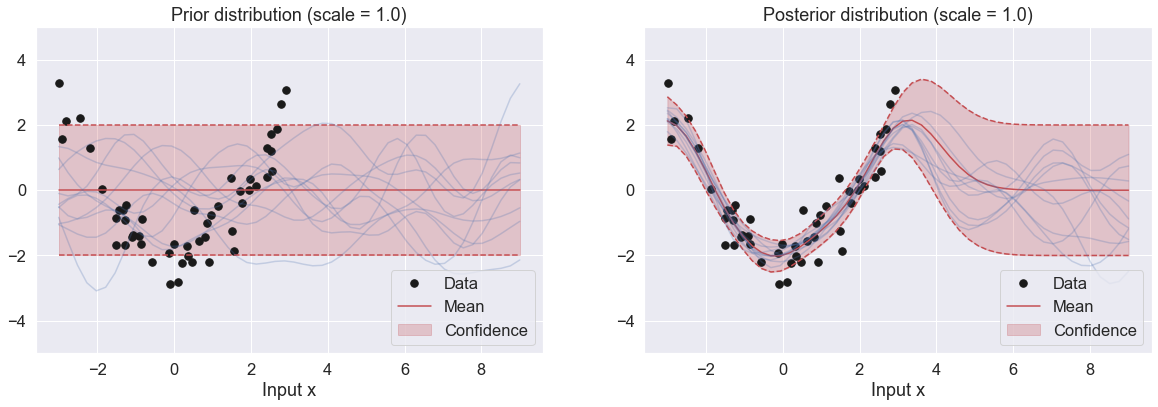

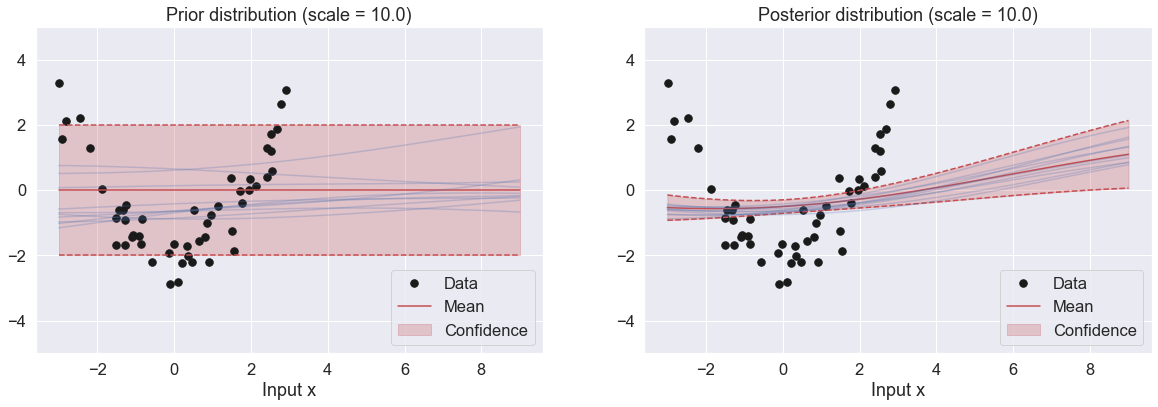

In [12]:
sigma2=0.5
alpha=1
scales = [0.1, 1., 10.]

###############################################
# ------- insert code here -------------------
###############################################

for scale in scales:
    
    mu_prior, Sigma_prior = posterior(Xp, np.zeros((0,1)), np.zeros((0,1)), alpha, scale, sigma2)
    mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plot_data()
    plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title=f'Prior distribution (scale = {scale})', num_samples=10)
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plot_data()
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title=f'Posterior distribution (scale = {scale})', num_samples=10)
    plt.legend(loc='lower right')

Difference between the figures with different scales:

As described previously, the scale parameter controls the smoothness of the prior samples. As the scale becomes larger, the gradual change between the dimension (Input X) becomes smoother, and as the scale becomes smaller, the samples become highly turbulent. This is observed in the prior distributions above.

For the posterior distributions, a smaller scale leads to a more peaked and narrower posterior distribution, while a larger scale hyperparameter will lead to a flatter distribution. Specifically, if the scale hyperparameter is too small, the GP posterior samples may overfit the training data and have high variance. On the other hand, if the scale hyperparameter is too large, the GP posterior samples may underfit the training data and have high bias

**Task 3e**: Replicate the two figures above for the following three different values of the alpa parameter: $\left\lbrace 0.25, 1, 5 \right\rbrace$ and for $\sigma^2 = \frac{1}{2}$ and $\text{scale}=1$. Explain the differences between the three sets of plots


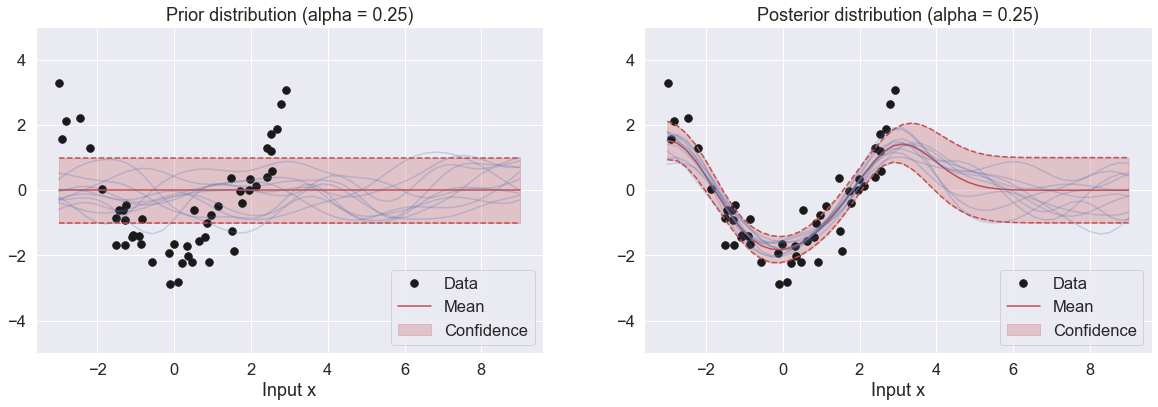

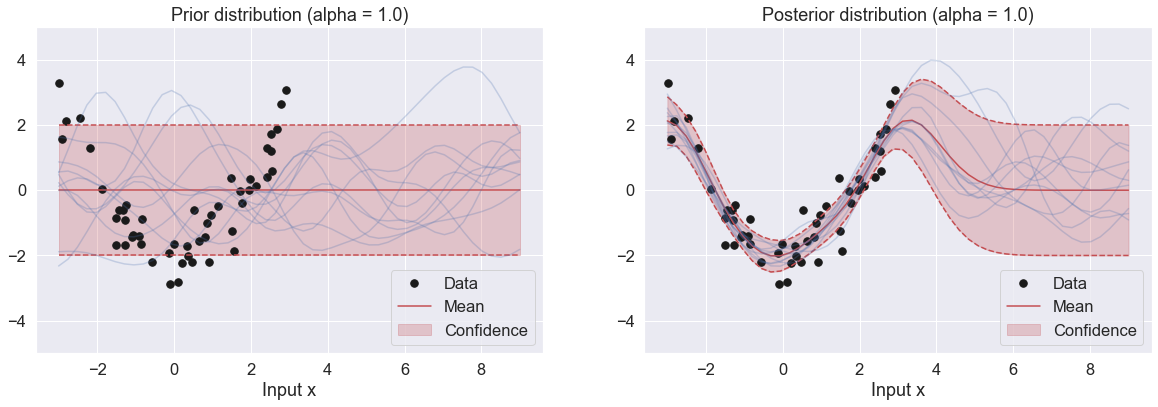

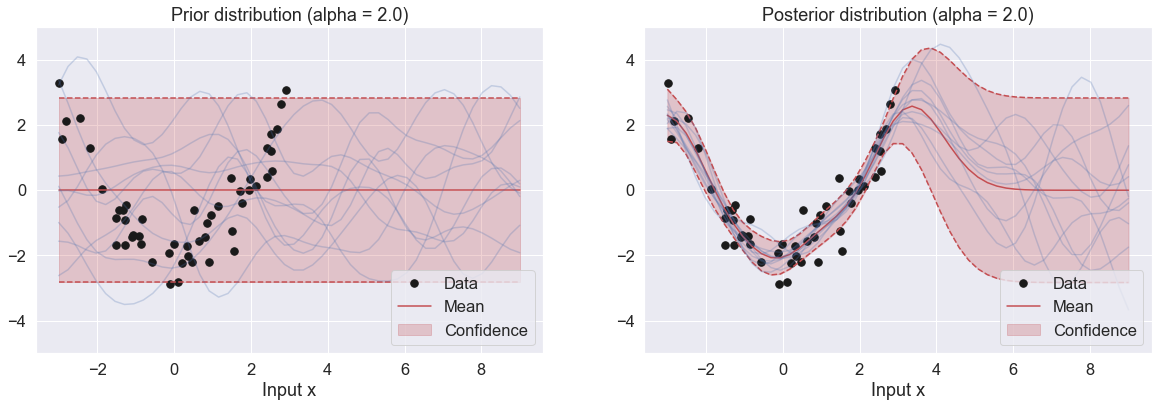

In [13]:
sigma2=0.5
scale=1
alphas = [0.25, 1., 2.]

###############################################
# ------- insert code here -------------------
###############################################

for alpha in alphas:
    
    mu_prior, Sigma_prior = posterior(Xp, np.zeros((0,1)), np.zeros((0,1)), alpha, scale, sigma2)
    mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plot_data()
    plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title=f'Prior distribution (alpha = {alpha})', num_samples=10)
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plot_data()
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title=f'Posterior distribution (alpha = {alpha})', num_samples=10)
    plt.legend(loc='lower right')

For the prior samples, the alpha parameter controls the magnitude of the samples. When alpha becomes larger, the range of the samples become wider and covers more uncertainty. Smaller alpha results in smaller variance, leading to a narrow range of the samples

For the posterior samples, small alphas try to match the regions with the most concentrated data points while discrading relative outliers. This is because the allowed confidence is small. Larger alphas are able to capture more datapoints because the allowed confidence level is higher.  

### Task 4: The marginal likelihood

The purpose of this task is to study the marginal likelihood $p(\mathbf{y})$ and see how it can be useful for model selection. 

The marginal likelihood is covered in lecture #3.

The marginal likelihood for a zero-mean Gaussian process model with Gaussian likelihood is given by

\begin{align}
p(\mathbf{y} \big| \theta) = \mathcal{N}\left(\bf{y} \big| \bf{0}, \bf{K} + \sigma^2 \bf{I}\right)
\end{align}

where $\theta$ are the set of hyperparameters, e.g. the alpha and scale parameters.

First, we will load some validation data that will be useful for evaluating the model.


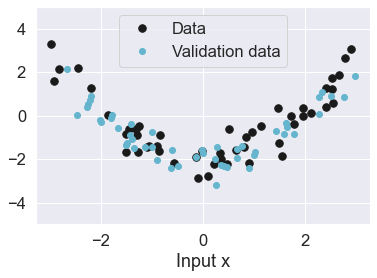

In [14]:
Nval, Xval, yval = data['Nval'], data['Xval'], data['yval']

plot_data()
plt.plot(Xval, yval, 'c.', label='Validation data', markersize=12)
plt.legend(loc='upper center');

**Task 4a**: Complete the implementation of the function <tt>predictive</tt> below. The predictive distribution of 'yp' combines prediction function posterior (<tt>posterior</tt>) and the noise variance.


In [15]:
def predictive(Xp, X, y, alpha, scale, sigma2):
    """ returns the predictive distribution of yp 
    evaluated at each of the points in Xp conditioned on (X, y)
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)
    N = len(Xp)
    mu_pred, Sigma_pred = mu_post, Sigma_post + sigma2 * np.eye(N)
    return mu_pred, Sigma_pred


**Task 4b**: Complete the implementation of the function <tt>MLPPD</tt> for computing the mean log posterior predictive density given below.


<img src="MLPPD.png">

In [16]:
log_pdf = lambda x, m, v: -0.5*(x-m)**2/v -0.5* np.log(2*np.pi*v)

# This function is also known as ELPD (Expected Log Pointwise Predictive Density)
def MLPPD(Xval, yval, mu, Sigma):
    """ returns the mean log posterior predictive density 
    for the data points (Xval, yval) wrt. predictive density N(mu, Sigma)
    
    Arguments:
    Xval      -- PxD input points
    yval      -- Px1 observed values 
    mu        -- Px1 mean of predictive distribution
    Sigma     -- PxP covariance of predictive distribution

    Returns
    mlppd     -- (scalar) mean log posterior predictive density
    
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    # Model answer
    var = np.diag(Sigma)
    mlppd = np.mean(log_pdf(yval,mu,var))
    return mlppd



**Task 4c**: Complete the implementation of the function <tt>log_marginal_likelihood</tt>  given below.


<img src="log_marginal_likelihood.png">

In [17]:
def log_marginal_likelihood(X, y, alpha, scale, sigma2):
    """ returns the log marginal likelihood for the data set (X, y) for the hyperparameters alpha, scale, sigma2
        The function also returns the components of the log marginal likelihood:
        
        log_ml = const_term + det_term + quad_term
    
    Arguments:
    X        -- NxD input points
    y        -- Nx1 observed values 
    alpha    -- alpha parameter
    scale    -- scale parameter
    sigma2   -- noise variance

    Returns:
    log_ml   -- (scalar) log marginal likelihood ( = const + det + quad)
    const    -- constant part of the log marginal lihood
    det      -- determinant part of the log marginal lihood
    quad     -- quadratic part of the log marginal lihood
    
    """
    N = len(X)
    K = create_se_kernel(X, X, alpha, scale)
    
    C = K + sigma2 * np.eye(N)
    jitter = 1e-8
    L = np.linalg.cholesky(C + jitter * np.eye(N))
    v = np.linalg.solve(L, y)
    
    const_term = - (N/2) * np.log(2 * np.pi)
    det_term = - 0.5 * 2 * np.sum(np.log(np.diag(L)))
    quad_term = -(1/2) * np.sum(v ** 2)
    log_ml = const_term + det_term + quad_term
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
        
    return log_ml, const_term, det_term, quad_term





**Task 4d**: Compute and plot the marginal likelihood as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. In the same figure, you should also plot the determinant and the quadractic part of the marginal likelihood. Note, that the scale values are distributed equally in log-space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logaritmic in the plot. Furthermore, locate the optimal value of the scale and plot the posterior distribution of $f(\bf{X}_p)$ for the that specific value.

The optimal scale value is 0.8697490026177834
Its respective log optimal scale value in the graph is -0.1395506116966087


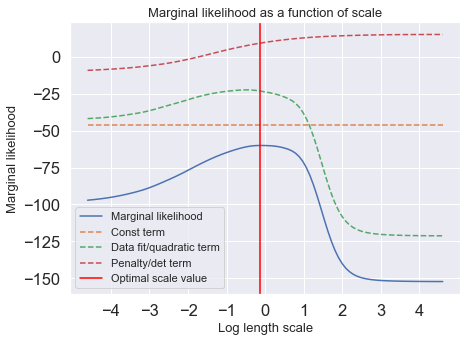

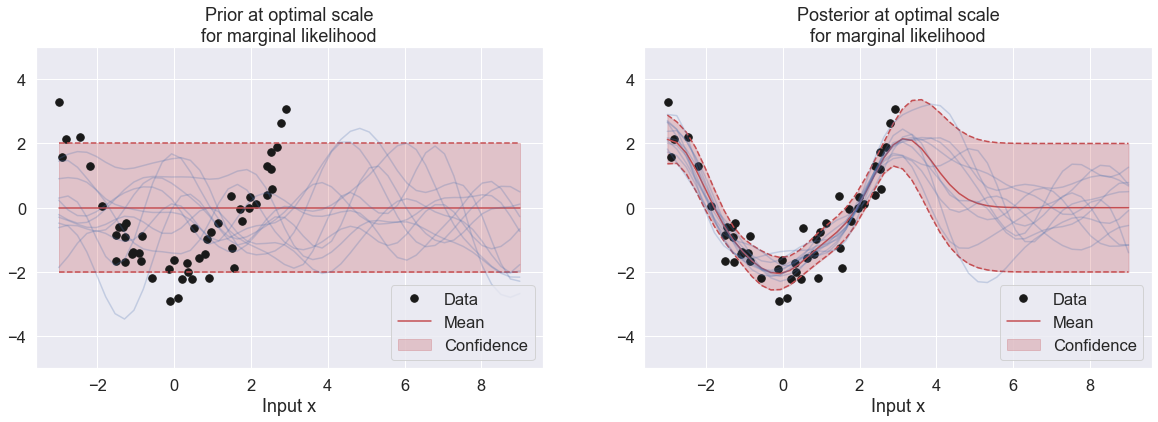

In [18]:
scales = np.logspace(-2, 2, 100)
sigma2=0.5
alpha=1

###############################################
# ------- insert code here -------------------
###############################################

# Should look like the figure in slide 34
log_ml_list = np.zeros(100)
const_list = np.zeros(100)
det_list = np.zeros(100)
quad_list = np.zeros(100)

for index, scale in enumerate(scales):
    log_ml, const_term, det_term, quad_term = log_marginal_likelihood(X, y, alpha, scale, sigma2)
    log_ml_list[index] = log_ml
    const_list[index] = const_term
    det_list[index] = det_term
    quad_list[index] = quad_term

log_scales = np.log(scales)

optimal_value_index = np.argmax(log_ml_list)
print(f"The optimal scale value is {scales[optimal_value_index]}")
print(f"Its respective log optimal scale value in the graph is {log_scales[optimal_value_index]}")

plt.figure(figsize=(7, 5))
plt.plot(log_scales, log_ml_list, label="Marginal likelihood")
plt.plot(log_scales, const_list, label="Const term",linestyle="--")
plt.plot(log_scales, quad_list, label="Data fit/quadratic term",linestyle="--")
plt.plot(log_scales, det_list, label="Penalty/det term",linestyle="--")

#plt.xscale('log', base=2)
plt.xticks([-4, -3, -2, -1, 0, 1, 2,3, 4])
plt.title("Marginal likelihood as a function of scale",fontsize=13)
plt.xlabel("Log length scale",fontsize=13)
plt.ylabel("Marginal likelihood",fontsize=13)
plt.axvline(x=log_scales[optimal_value_index], color='red', label="Optimal scale value")

plt.legend(loc=3, fontsize=11)
plt.show()

###############################################
# ------- insert code here -------------------
###############################################

sigma2=0.5
scale=scales[optimal_value_index]
alpha=1

mu_prior, Sigma_prior = posterior(Xp, np.zeros((0,1)), np.zeros((0,1)), alpha, scale, sigma2)
mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)

plt.figure(figsize=(20, 13))

plt.subplot(2, 2, 1)
plot_data()
plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title=f'Prior at optimal scale\nfor marginal likelihood', num_samples=10)
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title=f'Posterior at optimal scale\nfor marginal likelihood', num_samples=10)
plt.legend(loc='lower right')

plt.show()

**Task 4e**: Compute and plot the MLPPD of the validation set $\left( \bf{X}_{\text{val}}, \bf{y}_{\text{val}}\right)$ as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. Note, the scale values are distributed equally in log-space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logaritmic in the plot.

The optimal scale value is 2.4201282647943834
Its respective log optimal scale value in the graph is 0.8838205407451898


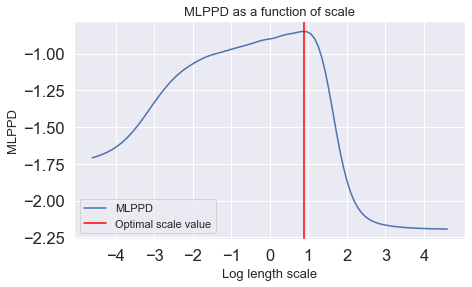

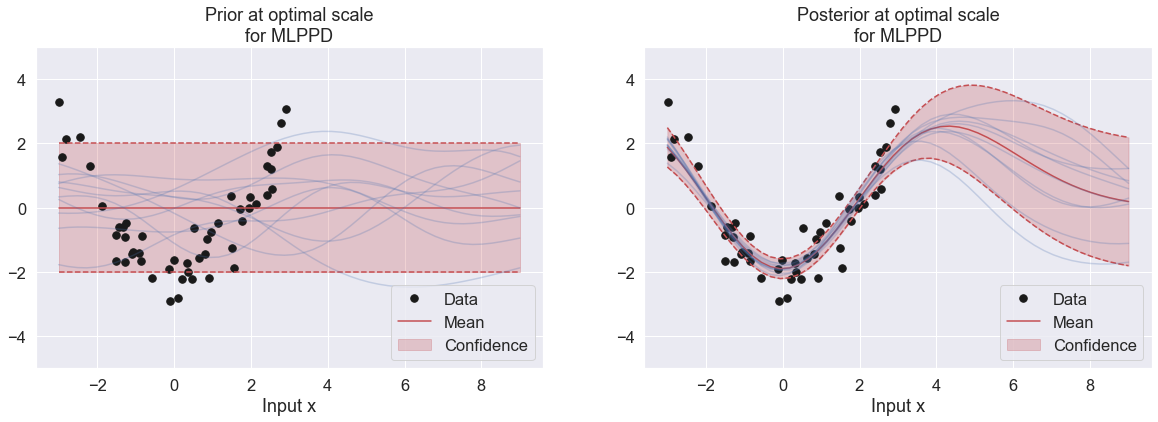

In [19]:
scales = np.logspace(-2, 2, 100)
sigma2=0.5
alpha=1

###############################################
# ------- insert code here -------------------
###############################################

mlppd_list = np.zeros(100)
for index, scale in enumerate(scales):
    mu_val, Sigma_val = predictive(Xval, X, y, alpha, scale, sigma2)
    mlppd = MLPPD(Xval, yval, mu_val, Sigma_val)
    mlppd_list[index] = mlppd

optimal_value_index = np.argmax(mlppd_list)
print(f"The optimal scale value is {scales[optimal_value_index]}")
print(f"Its respective log optimal scale value in the graph is {log_scales[optimal_value_index]}")

plt.figure(figsize=(7, 4))
plt.plot(log_scales, mlppd_list, label="MLPPD")

#plt.xscale('log', base=2)
plt.xticks([-4, -3, -2, -1, 0, 1, 2,3, 4])
plt.title("MLPPD as a function of scale",fontsize=13)
plt.xlabel("Log length scale",fontsize=13)
plt.ylabel("MLPPD",fontsize=13)
plt.legend(loc=4, fontsize=11)

plt.axvline(x=log_scales[optimal_value_index], color='red', label="Optimal scale value")

plt.legend(loc=3, fontsize=11)
plt.show()

###############################################
# ------- insert code here -------------------
###############################################

sigma2=0.5
scale=scales[optimal_value_index]
alpha=1

mu_prior, Sigma_prior = posterior(Xp, np.zeros((0,1)), np.zeros((0,1)), alpha, scale, sigma2)
mu_post, Sigma_post = posterior(Xp, X, y, alpha, scale, sigma2)

plt.figure(figsize=(20, 13))

plt.subplot(2, 2, 1)
plot_data()
plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title=f'Prior at optimal scale\nfor MLPPD', num_samples=10)
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title=f'Posterior at optimal scale\nfor MLPPD', num_samples=10)
plt.legend(loc='lower right')

plt.show()

**Task 4f**: Compare the two plots above and explain what you see. 

The log marginal likelihood and MLPPD can both be used for hyperparameter tuning in Gaussian process regression with an RBF kernel. The difference between them is that the log marginal likelihood is a measure of hyperparameters that maximizes the model fitness on the training data. On the other hand,  the MLPPD is a measure of hyperparameters that maximizes the model fitness on new data prediction. As a result, a model with a high log marginal likelihood indicates a good fit to the training data, while a model with a high MLPPD indicates good predictive performance.

In this exercise, the optimal scale value for MLPPD is much larger than the log marginal likelihood, suggesting that MLPPD prefers larger bias than log marginal likelihood, as MLPPD can be observed to have a smoother transition to static prior region as compared to the log marginal likelihood. This suggests that MLPPD takes into account the future prediction (as its name implies), thus having lower variance than log marginal likelihood (which only aims to fit the training data) and follows the flow of the data pattern. 